In [7]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.spatial.distance as spsd
from sklearn import preprocessing

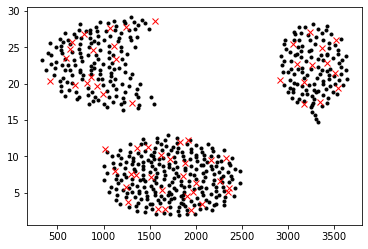

In [3]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 1 ])

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.show()

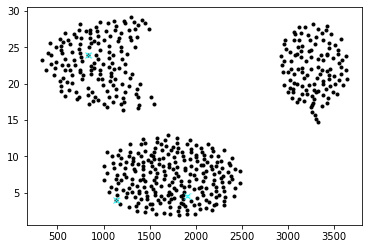

In [4]:
def pick_cluster_centers(array, k):
    centers = []
    for i in range(k):
        p_dist = np.ones(array.shape[0])
        for j in range(array.shape[0]):
            if centers:
                distances = spsd.cdist(np.array([array[j]]), centers)
                p_dist[j] = min(distances)[0]
        p_dist /= sum(p_dist)
        ai = np.random.choice(array.shape[0], p = p_dist)
        centers.append(array[ai])
    return np.array(centers)

centers = pick_cluster_centers(data, 3)

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(centers[:,0], centers[:,1], 'x', color='cyan')
plot.show()

In [5]:
def kmeans(array, k):
    centers = pick_cluster_centers(array, k)

    changed = True
    while (changed):
        distances = spsd.cdist(array, centers)
        indices = np.argmin(distances, axis=1)
        print(indices)
        
        # falta agrupar os valores, tirar a média da posição por cluster e alterar os centros
        
        # deveria ser falso somente quando centros não estão se movendo (ou estão movendo pouco)
        changed = False
    return centers
cluster_centers = kmeans(data, 3)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

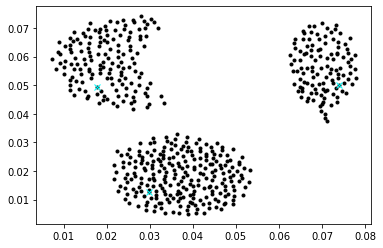

In [11]:
def normalize(array):
    normalized_array = preprocessing.normalize(array, axis=0)
    return normalized_array

new_training = normalize(training)
new_centers = kmeans(new_training, 3)

plot.plot(new_training[:,0], new_training[:,1], '.', color='black')
plot.plot(new_centers[:,0], new_centers[:,1], 'x', color='cyan')
plot.show()

In [27]:
import json

def covid_dataset_cleaner(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    matriz = {}
    notCountries = ["World", "Africa", "Europe", "European Union", "Asia", "North America", "South America", "Oceania", "International"]

    for country in data:
        if not (data[country]['location'] in notCountries):
            location = data[country]['location']
            newCountry = []
            
            lastMonth = str(data[country]['data'][0]['date'][5]) + str(data[country]['data'][0]['date'][6]) + '/' + str(data[country]['data'][0]['date'][2]) + str(data[country]['data'][0]['date'][3])
            lastData = []
            
            if lastMonth == '04/20':
                newCountry.append([0, '2020-03-31'])
            
            elif lastMonth == '05/20':
                newCountry.append([0, '2020-03-31'])
                newCountry.append([0, '2020-04-30'])

            for daysInformation in data[country]['data']:
                newMonth = str(daysInformation['date'][5]) + str(daysInformation['date'][6]) + '/' + str(daysInformation['date'][2]) + str(daysInformation['date'][3])

                if newMonth == '01/20' or newMonth == '02/20':
                    lastMonth = '03/20'
                    continue

                if lastMonth != newMonth:
                    newCountry.append(lastData)

                deaths = 0
                if 'total_deaths' in daysInformation:
                    deaths = daysInformation['total_deaths']

                lastMonth = newMonth
                lastData =  [deaths, daysInformation['date']]
                
            if len(newCountry) == 13:
                j += 1
                matriz[location] = newCountry
                
    # teste = []
    # for country in matriz:
        # print(country, ":", len(matriz[country]))
    

    return matriz


covid_dataset = covid_dataset_cleaner('covid-data.json')
print(covid_dataset)

UnboundLocalError: local variable 'j' referenced before assignment